In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from Higgs.tools.ImplementationUtils import (
    readHEPDataCsv,
    implementPairDecayLimit,
    fromHB5Table1,
    implementPairProductionLimit,
)
from Higgs import bounds as HB
from Higgs import predictions as HP
from Higgs import Predictions

import os, sys

sys.path.insert(0, os.path.dirname(os.path.dirname(os.path.dirname(os.getcwd()))))
import MassResolutions as resolution


# ATLAS 13TeV LHC

## `H > hSM hSM > bbtautau` [1808.00336](https://arxiv.org/abs/1808.00336)


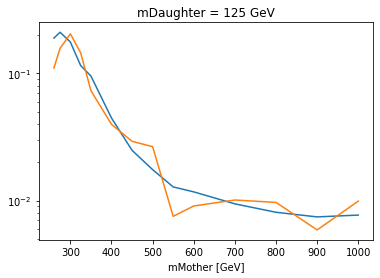

Looks good. Saving this to H_LHC13_ATLAS_36.json


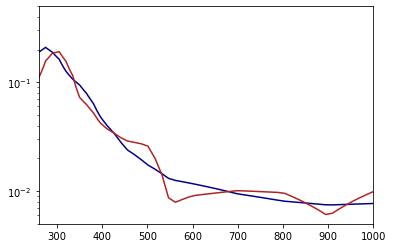

In [2]:
dfs = readHEPDataCsv(
    "https://www.hepdata.net/download/table/ins1684645/Table%203/1/csv"
)
df = dfs[0].rename(
    columns={
        "Mass [GeV]": "mMother",
        "Cross section upper limit at 95% CL [fb]": "obs",
    }
)
assert np.allclose(df.mMother, dfs[1]["Mass [GeV]"])
df["exp"] = dfs[1]["Cross section upper limit at 95% CL [fb]"]
# fb to pb
df.exp *= 1e-3
df.obs *= 1e-3
df["mDaughter1"] = 125

limitFile = implementPairDecayLimit(
    "1808.00336",
    {
        "production": ["H"],
        "firstDecay": ["tautau"],
        "secondDecay": ["bb"],
    },
    "https://doi.org/10.17182/hepdata.83539.v1/t3",
    df,
    massResolution={  # all guesses, they don't say anything
        "firstDaughter": resolution.tautau["default"],
        "secondDaughter": resolution.bb["medMass"],
        "mother": resolution.bb["highMass"],
    },
)
lim = HB.Limit(limitFile)

pred = Predictions()
hh = pred.addParticle(HP.NeutralScalar("hh"))
h1 = pred.addParticle(HP.NeutralScalar("h1"))
h2 = pred.addParticle(HP.NeutralScalar("h2"))
hh.setDecayWidth("h1", "h2", 1.0)
h1.setDecayWidth("bb", 1)
h2.setDecayWidth("tautau", 1)
h2.setMass(125)
h1.setMass(125)
hm = np.linspace(260, 1000)
r = np.linspace(5e-3, 0.5)


def testAgainstLimit(mass, rate):
    hh.setMass(mass)
    hh.setCxn("LHC13", "ggH", rate)
    app = lim.apply(pred)
    if len(app) == 0:
        print("Limit not applied for ", mass, rate)
        return (0, 0)
    return (app[0].expRatio(), app[0].obsRatio())


test = np.frompyfunc(testAgainstLimit, 2, 2)
XX, YY = np.meshgrid(hm, r)
expR, obsR = test(XX, YY)
fig, ax = plt.subplots()
ax.set_yscale("log")
expCc = ax.contour(hm, r, expR, levels=[1], colors=["darkblue"])
obsCc = ax.contour(hm, r, obsR, levels=[1], colors=["firebrick"])
expCc.collections[0].set_label("expRatio = 1")
obsCc.collections[0].set_label("obsRatio = 1")


## non-res `pp > hSM hSM > bbtautau`  [1808.00336](https://arxiv.org/abs/1808.00336)

In [3]:
df = pd.DataFrame({"m": [125], "obs": 30.9e-3, "exp": 36.1e-3})
limitFile = implementPairProductionLimit(
    "1808.00336",
    {"firstDecay": ["bb"], "secondDecay": ["tautau"]},
    "Tab. 3",
    df,
    idSuffix=1,
    massResolution={  # guess +-20
        "firstParticle": {"absolute": 40, "relative": 0.0},
        "secondParticle": {"absolute": 40, "relative": 0.0},
    },
)

lim = HB.Limit(limitFile)

pred = Predictions()
h1 = pred.addParticle(HP.NeutralScalar("h1"))
h1.setDecayWidth("bb", 1.0)
h1.setMass(125)
h2 = pred.addParticle(HP.NeutralScalar("h2"))
h2.setDecayWidth("tautau", 1.0)
h2.setMass(125)
pred.setBsmPairCxn("LHC13", "h1", "h2", 1.0)
res = lim.apply(pred)
print(res)
assert np.isclose(res[0].obsRatio(), 1.0 / df.obs[0])
assert np.isclose(res[0].expRatio(), 1.0 / df.exp[0])


Looks good. Saving this to nonres_LHC13_ATLAS_36.json
[<Higgs.bounds.AppliedLimit limitId: 1808003361, obsRatio: 32.362, expRatio: 27.701, for: ["h1", "+", "h2"]>]


## `H > hSM hSM > bbtautau` boosted [2007.14811](https://arxiv.org/abs/2007.14811)


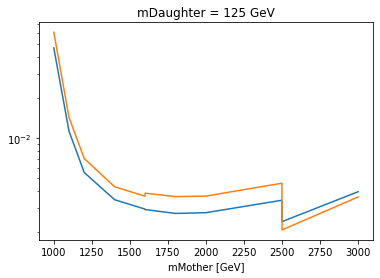

Looks good. Saving this to H_boosted_LHC13_ATLAS_139.json


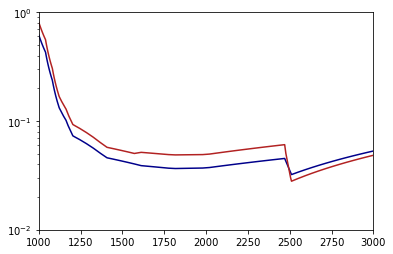

In [3]:
dfs = readHEPDataCsv(
    "https://www.hepdata.net/download/table/ins1809175/Table%204/2/csv"
)
df = dfs[0].rename(columns={"Mass [GeV]": "mMother", "Observed [fb]": "obs"})
assert np.allclose(df.mMother, dfs[1]["Mass [GeV]"])
df["exp"] = dfs[1][r"Expected $\pm 1\sigma$ [fb]"]
refBr = 2 * HP.SMHiggs(125).br("bb") * HP.SMHiggs(125).br("tautau")
# fix masses at selection region transitions
df.loc[4, "mMother"] -= 1
df.loc[8, "mMother"] -= 1
# pb to fb and BR(HH > bb tautau)
df.exp *= 1e-3 * refBr
df.obs *= 1e-3 * refBr
df["mDaughter1"] = 125
limitFile = implementPairDecayLimit(
    "2007.14811",
    {
        "production": ["H"],
        "firstDecay": ["bb"],
        "secondDecay": ["tautau"],
    },
    "https://doi.org/10.17182/hepdata.95432.v2/t4",
    df,
    massResolution={
        "firstDaughter": {"absolute": 30, "relative": 0},  # guess
        "secondDaughter": {"absolute": 45, "relative": 0},  # guess
        "mother": resolution.bb["highMass"],
    },
    prefix="H_boosted",
)
lim = HB.Limit(limitFile)

pred = Predictions()
hh = pred.addParticle(HP.NeutralScalar("hh"))
h1 = pred.addParticle(HP.NeutralScalar("h1"))
h2 = pred.addParticle(HP.NeutralScalar("h2"))
hh.setDecayWidth("h1", "h2", 1.0)
h1.setDecayWidth("tautau", 1.0)
h2.setDecayWidth("bb", 1.0)
h1.setMass(125)
h2.setMass(125)
hm = np.linspace(1000, 3000)
r = np.linspace(1e-2, 1)


def testAgainstLimit(mass, rate):
    hh.setMass(mass)
    hh.setCxn("LHC13", "ggH", rate * refBr)
    app = lim.apply(pred)
    if len(app) == 0:
        print("Limit not applied for ", mass, rate)
        return (0, 0)
    return (app[0].expRatio(), app[0].obsRatio())


test = np.frompyfunc(testAgainstLimit, 2, 2)
XX, YY = np.meshgrid(hm, r)
expR, obsR = test(XX, YY)
fig, ax = plt.subplots()
ax.set_yscale("log")
expCc = ax.contour(hm, r, expR, levels=[1], colors=["darkblue"])
obsCc = ax.contour(hm, r, obsR, levels=[1], colors=["firebrick"])
expCc.collections[0].set_label("expRatio = 1")
obsCc.collections[0].set_label("obsRatio = 1")


# ATLAS 8TeV LHC

## `H > hSM hSM > bbtautau` [1509.04670](https://arxiv.org/abs/1509.04670)
The quoted limit does not include the BRs of daughter higgses, but assumes hSM. We multiply the limits with the reference BRs and then include the Higgs decays in the process definition.

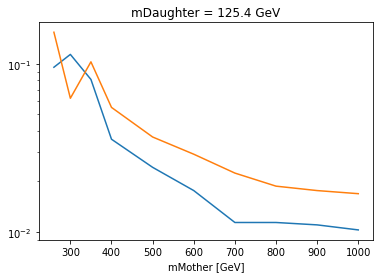

Looks good. Saving this to H_LHC8_ATLAS_20.json


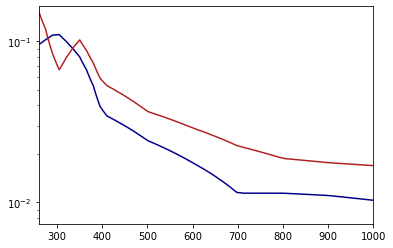

In [5]:
df = pd.DataFrame(
    data={
        "mMother": [260, 300, 350, 400, 500, 600, 700, 800, 900, 1000],
        "exp": [2.6, 3.1, 2.2, 0.97, 0.66, 0.48, 0.31, 0.31, 0.3, 0.28],
        "obs": [4.2, 1.7, 2.8, 1.5, 1, 0.79, 0.61, 0.51, 0.48, 0.46],
        "mDaughter1": 125.4,  # page 16
    }
)
ref = HP.SMHiggs(125.4)
refDec = ref.br("bb") * ref.br("tautau")
df.exp *= refDec
df.obs *= refDec

limitFile = implementPairDecayLimit(
    "1509.04670",
    {
        "production": ["H"],
        "firstDecay": ["bb"],
        "secondDecay": ["tautau"],
    },
    "Tab. 6",
    df,
    massResolution={
        "firstDaughter": {"absolute": 30, "relative": 0},  # 90-160 mbb signal region
        "secondDaughter": {
            "absolute": 20,
            "relative": 0,
        },  # 100 - 150 mtautau signal region
        "mother": {
            "absolute": 30,
            "relative": 0.05,
        },  # the quoted resolutions assume exactly 125 GeV
    },
    idSuffix=2,  # the other ids are different final states
)
lim = HB.Limit(limitFile)

pred = Predictions()
hh = pred.addParticle(HP.NeutralScalar("hh"))
hh.setDecayWidth("h1", "h2", 1.0)
h1 = pred.addParticle(HP.NeutralScalar("h1"))
h1.setMass(125)
h1.setDecayWidth("bb", 1.0)
h2 = pred.addParticle(HP.NeutralScalar("h2"))
h2.setMass(125)
h2.setDecayWidth("tautau", 1.0)
hm = np.linspace(260, 1000)
r = np.linspace(0.2 * refDec, 4.5 * refDec)


def testAgainstLimit(mass, rate):
    hh.setMass(mass)
    hh.setCxn("LHC8", "ggH", rate)
    app = lim.apply(pred)
    if len(app) == 0:
        print("Limit not applied for ", mass, rate)
        return (0, 0)
    return (app[0].expRatio(), app[0].obsRatio())


test = np.frompyfunc(testAgainstLimit, 2, 2)
XX, YY = np.meshgrid(hm, r)
expR, obsR = test(XX, YY)
fig, ax = plt.subplots()
ax.set_yscale("log")
expCc = ax.contour(hm, r, expR, levels=[1], colors=["darkblue"])
obsCc = ax.contour(hm, r, obsR, levels=[1], colors=["firebrick"])
expCc.collections[0].set_label("expRatio = 1")
obsCc.collections[0].set_label("obsRatio = 1")
plt.show()
